In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from scipy import stats
from matplotlib.colors import TwoSlopeNorm
import regionmask
import pandas as pd
from matplotlib import colors


In [10]:
def linear_trend(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope, intercept, p_value

import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import matplotlib.gridspec as gridspec

NS_PER_YEAR = 3.15576e16  # nanoseconds in a (Julian) year

def linear_trend_per_year(time_coord, y):
    """Return (slope_per_year, p_value). Works for datetime64 or numeric years."""
    if np.issubdtype(time_coord.dtype, np.datetime64):
        x = time_coord.astype('datetime64[ns]').astype('int64')  # ns since epoch
        unit_factor = NS_PER_YEAR  # convert slope from per-ns → per-year
    else:
        x = np.asarray(time_coord, dtype=float)  # already years
        unit_factor = 1.0

    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    slope, _, _, p_value, _ = stats.linregress(x[mask], y[mask])
    return slope * unit_factor, p_value


def plot_final_eight_indices(data, ylabel_list, filename='./Figures/Figure_3.png'):
    fig = plt.figure(figsize=(16, 5))
    spec = gridspec.GridSpec(2, 4, wspace=0.3, hspace=0.4)

    panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)','(g)','(h)']
    font_main = {'fontsize': 10}
    font_label = {'fontsize': 9}

    legend_handles = None

    for i, (label, time, original, trend, residual) in enumerate(data):
        ax = fig.add_subplot(spec[i])

        # --- compute trends per year for BOTH red (CMIP6/original) and blue (Trend) ---
        slope_red_yr, p_red = linear_trend_per_year(time, original.values)  # CMIP6
        slope_blue_yr, p_blue = linear_trend_per_year(time, trend.values)   # Observed/blue

        # --- plot three series ---
        line_orig,  = ax.plot(time, original, color='red',  linewidth=1,   label='CMIP6')
        line_trend, = ax.plot(time, trend,    color='blue', linewidth=1.5, label='Trend')
        line_resid, = ax.plot(time, residual, color='gray', linewidth=1,   label='Residual')

        # save handles just once
        if legend_handles is None:
            legend_handles = [line_orig, line_trend, line_resid]

        # cosmetics
        ax.axhline(0, linestyle='--', color='black', linewidth=0.5)
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
        ax.set_title(f"{panel_labels[i]} {ylabel_list[i]}", **font_main)
        ax.tick_params(labelsize=8)
        if i >= 3:
            ax.set_xlabel("Time", **font_label)
        ax.set_ylabel(ylabel_list[i], fontsize=9)

        # --- annotation text ---
        txt_red  = f"Trend = {slope_red_yr:.3g}/yr\np = {p_red:.2g}"
        txt_blue = f"Trend = {slope_blue_yr:.3g}/yr\np = {p_blue:.2g}"
        
        common_kw = dict(fontsize=8,
                         bbox=dict(facecolor='white', alpha=0.65,
                                   edgecolor='none', boxstyle='round,pad=0.2'))
        
        if i in [0, 1, 2,4,5]:  # top row
            ax.text(0.02, 0.98, txt_red, transform=ax.transAxes,
                    ha='left', va='top', color='red', **common_kw)
            ax.text(0.98, 0.02, txt_blue, transform=ax.transAxes,
                    ha='right', va='bottom', color='blue', **common_kw)
        
        elif i in [3,6]:  # middle row
            ax.text(0.02, 0.98, txt_red, transform=ax.transAxes,
                    ha='left', va='top', color='red', **common_kw)
            ax.text(0.98, 0.98, txt_blue, transform=ax.transAxes,
                    ha='right', va='top', color='blue', **common_kw)
        
        elif i == 7:  # last panel
            ax.text(0.02, 0.02, txt_red, transform=ax.transAxes,
                    ha='left', va='bottom', color='red', **common_kw)
            ax.text(0.98, 0.02, txt_blue, transform=ax.transAxes,
                    ha='right', va='bottom', color='blue', **common_kw)

    # Shared legend
    if legend_handles is not None:
        fig.legend(
            legend_handles,
            ['CMIP6', 'Trend', 'Residual'],
            loc='lower center',
            bbox_to_anchor=(0.5, -0.03),
            ncol=3,
            fontsize=9,
            frameon=False
        )

    plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

In [5]:
ds_gt_y = xr.open_dataset('../New_Analysis/Smoothed_files/trend_global_mean_T_yearly_nt6.nc')
ds_hg_y = xr.open_dataset('../New_Analysis/Smoothed_files/trend_inter_hemispheric_gradient_yearly_nt6.nc')
ds_lsg_y = xr.open_dataset('../New_Analysis/Smoothed_files/trend_land_sea_gradient_global_yearly_nt6.nc')
ds_nino_y = xr.open_dataset('../New_Analysis/Smoothed_files/trend_nino_3_4_yearly_nt6.nc')
ds_tni_y = xr.open_dataset('../New_Analysis/Smoothed_files/trend_trans_nino_index_TNI_yearly_nt6.nc')
ds_eqpo_y = xr.open_dataset('../New_Analysis/Smoothed_files/trend_pacific_sst_gradient_WPO_EPO_yearly_nt6.nc')
ds_epo_y = xr.open_dataset('../New_Analysis/Smoothed_files/trend_EPO_yearly_nt6.nc')
ds_wpo_y = xr.open_dataset('../New_Analysis/Smoothed_files/trend_WPO_yearly_nt6.nc')

In [6]:
ds_y = xr.open_dataset('climate_timeseries_indices_CMIP6.nc')

In [7]:
gt_tr_y=ds_gt_y.global_mean_T_trend
gt_re_y=ds_gt_y.global_mean_T_residual
hg_tr_y=ds_hg_y.inter_hemispheric_gradient_trend
hg_re_y=ds_hg_y.inter_hemispheric_gradient_residual
lsg_tr_y=ds_lsg_y.land_sea_gradient_global_trend
lsg_re_y=ds_lsg_y.land_sea_gradient_global_residual
nino_tr_y=ds_nino_y.nino_3_4_trend
nino_re_y=ds_nino_y.nino_3_4_residual
tni_hf_y=ds_tni_y.trans_nino_index_TNI_trend
tni_lf_y=ds_tni_y.trans_nino_index_TNI_residual
eqpo_tr_y=ds_eqpo_y.pacific_sst_gradient_WPO_EPO_trend
eqpo_re_y=ds_eqpo_y.pacific_sst_gradient_WPO_EPO_residual
epo_tr_y=ds_epo_y.EPO_trend
epo_re_y=ds_epo_y.EPO_residual
wpo_tr_y=ds_wpo_y.WPO_trend
wpo_re_y=ds_wpo_y.WPO_residual

gt_or_y = ds_y.global_mean_T
hg_or_y = ds_y.inter_hemispheric_gradient
lsg_or_y = ds_y.land_sea_gradient_global
nino_or_y = ds_y.nino_3_4
tni_or_y = ds_y.trans_nino_index_TNI
eqpo_or_y = ds_y.pacific_sst_gradient_WPO_EPO
epo_or_y = ds_y.EPO
wpo_or_y = ds_y.WPO

In [9]:
yearly_data = [
    ('Global Mean T', ds_y.year, gt_or_y, gt_tr_y, gt_re_y),
    ('Hemispheric T Gradient', ds_y.year, hg_or_y, hg_tr_y, hg_re_y),
    ('Land-Sea T Gradient', ds_y.year, lsg_or_y, lsg_tr_y, lsg_re_y),
    ('Niño3.4', ds_y.year, nino_or_y, nino_tr_y, nino_re_y),
    ('TNI', ds_y.year, tni_or_y, tni_hf_y, tni_lf_y),
    ('IPWP SST', ds_y.year, wpo_or_y, wpo_tr_y, wpo_re_y),
    ('EEPO SST', ds_y.year, epo_or_y, epo_tr_y, epo_re_y),
    ('IPWP-EEPO SST Gradient', ds_y.year, eqpo_or_y, eqpo_tr_y, eqpo_re_y),]
filtered_data = yearly_data

ylabel_list = [
    'Global Mean T (°C)',
    'Hemispheric T Gradient (°C)',
    'Land-Sea T Gradient (°C)',
    'Niño3.4 Index (°C)',
    'TNI (°C)',
    'IPWP SST (°C)',
    'EEPO SST (°C)',
    'IPWP–EEPO SST Gradient (°C)'
    
]

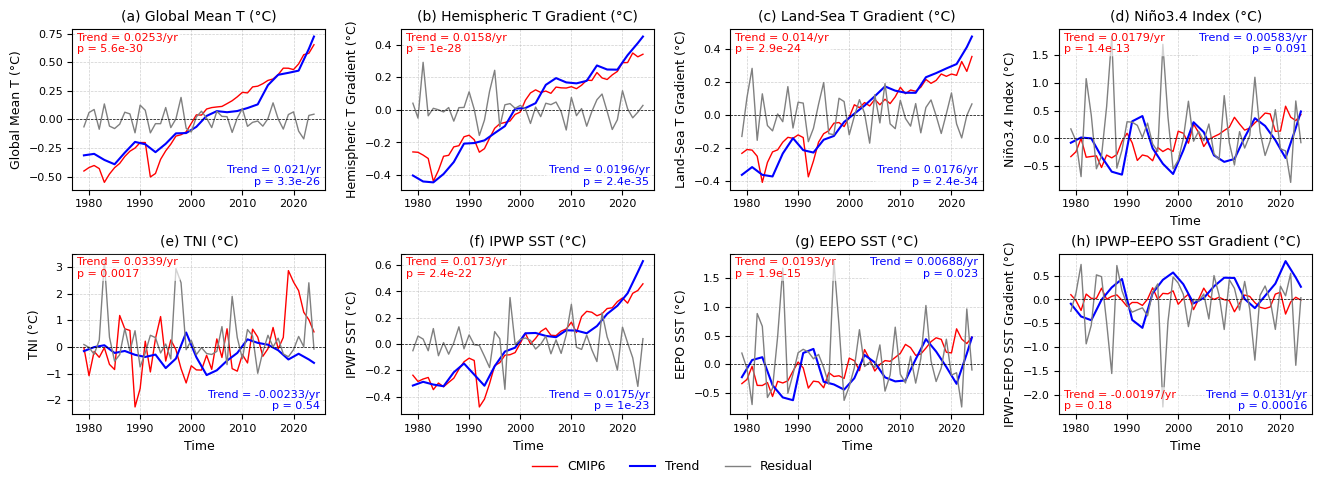

In [11]:

# Call the plotting function
plot_final_eight_indices(filtered_data, ylabel_list)
